# I Questions

1. **Leave-One-Out (LOO)**

Leave-One-Out — это метод кросс-валидации, где каждый пример по очереди используется для тестирования, а остальные — для обучения.

Плюсы:
- Полное использование данных.
- Хорош для маленьких наборов.

Минусы:
- Очень медленный для больших данных.
- Может привести к переобучению.

2. **Grid Search, Randomized Grid Search и Bayesian Optimization**

Grid Search: Перебирает все комбинации гиперпараметров. Очень долго.

Randomized Grid Search: Случайно выбирает комбинации, быстрее, но менее точен.

Bayesian Optimization: Использует вероятностные модели для поиска оптимальных параметров, более эффективно.

3. **Методы выбора признаков**

Фильтрационные: Оценивают признаки отдельно.

Pearson: Смотрит на линейную зависимость.

Chi2: Сравнивает частоты категорий.

Обертка: Используют модель для выбора.

Lasso: Уменьшает неважные признаки.

Встраиваемые: Включают выбор в обучение.

Permutation Significance: Проверяет важность признаков, перемешивая их.

SHAP: Объясняет предсказания модели, показывая, как каждый признак влияет на результат.

# II Introducion

## Import modules

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from itertools import product
import optuna

from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from collections import Counter

## Read Data

In [5]:
df_train = pd.read_json('data/train.json')
df_test = pd.read_json('data/test.json')

## Preprocessing features

In [6]:
encoder = LabelEncoder()
df_train['interest_level'] = encoder.fit_transform(df_train['interest_level'])
df_train['bathrooms'] = df_train['bathrooms'].astype(int)
df_test['bathrooms'] = df_test['bathrooms'].astype(int)
df_test.loc[:, 'interest_level'] = df_train['interest_level'].mode()[0]
df_train['created'] = pd.to_datetime(df_train['created'])
df_test['created'] = pd.to_datetime(df_test['created'])

In [7]:
features_all = []

for features in df_train['features']:
    if features:
        features_all += features

counter = Counter(features_all)
most_common_features = counter.most_common(20)

features_list = [feature_name.replace(' ', '') 
                 for feature_name, _ in most_common_features]

for feature in features_list:
    df_train[feature] = df_train['features'].apply(lambda x: 1 if feature 
                                            in [f.replace(' ', '') for f in x] else 0)
    df_test[feature] = df_test['features'].apply(lambda x: 1 if feature 
                                            in [f.replace(' ', '') for f in x] else 0)
    
df_train = df_train.drop(columns=['features'])
df_test = df_test.drop(columns=['features'])

In [8]:
df_train.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,latitude,listing_id,longitude,manager_id,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
4,1,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,...,0,0,0,1,0,0,0,0,0,0
6,1,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,...,0,0,0,0,0,0,0,0,0,0


# III Splits data

## Split to train and test

In [9]:
def my_split_train_test(X, y, test_size, random_state=None, shuffle=False):
    
    if random_state is not None:
        np.random.seed(random_state)
        
    indices = np.arange(hape[0]) # массив индексов выборки
    
    if shuffle:
        np.random.shuffle(indices) # перемешивание индексов
    
    total_size = int(len(X))
    test_size = int(total_size * test_size)
    
    train_indices = indices[:total_size - test_size]
    test_indices = indices[total_size - test_size:]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

## Split to train, validation and test

In [10]:
def my_split_train_validate_test_split(X, y, validation_size, test_size, random_state=None, shuffle=False):
    
    if validation_size + test_size >= 1:
        raise CustomError("Sum of validation_size and test_size must be < 1.")
    
    if random_state is not None:
        np.random.seed(random_state)
        
    indices = np.arange(X.shape[0])
    
    if shuffle:
        np.random.shuffle(indices)
        
    train_size = 1 - (validation_size + test_size)
    train_size = int(len(X) * train_size)    
    valid_size = int(len(X) * validation_size)
    test_size = len(X) - train_size - valid_size  
    
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices = indices[train_size + valid_size:] 
    
    # используем .iloc для корректной индексации по датасету
    X_train, X_valid, X_test = X.iloc[train_indices], X.iloc[valid_indices], X.iloc[test_indices]
    y_train, y_valid, y_test = y.iloc[train_indices], y.iloc[valid_indices], y.iloc[test_indices]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

## Split by date_time

In [11]:
def my_split_by_datetime(X, y, date_split, date_column):
    
    if date_column not in X.columns:
        raise ValueError(f'column {date_column} not in df')
        
    mask = X[date_column] < date_split
    
    X_train = X[mask]
    X_test = X[~mask]
    y_train = y[mask]
    y_test = y[~mask]
    
    return X_train, X_test, y_train, y_test

## Split by date_time(valid)

In [12]:
def my_split_by_val_datetime(X, y, validation_date, test_date, date_column):
    
    if date_column not in X.columns:
        raise ValueError(f'column {date_column} not in df')
        
    train_mask = X[date_column] < validation_date
    valid_mask = (X[date_column] >= validation_date) & (X[date_column] < test_date)

    X_train = X[train_mask]
    X_valid = X[valid_mask]
    X_test = X[test_mask]
    
    y_train = y[train_mask]
    y_valid = y[valid_mask]
    y_test = y[test_mask]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

# IV Cross-validation methods

## KFold

In [13]:
def k_fold_split(X, k):
    n_samples = len(X)
    indices = np.arange(n_samples)
    folds = np.array_split(indices, k)
    
    splits = []
    for i in range(k):
        test_index = folds[i]
        train_index = np.concatenate(folds[:i] + folds[i+1:])
        splits.append((train_index, test_index))
    
    return splits

## GroupKFold

In [14]:
def group_k_fold_split(X, groups, k):
    unique_groups = np.unique(groups)
    n_groups = len(unique_groups)
    group_indices = {group: np.where(groups == group)[0] for group in unique_groups}

    folds = np.array_split(unique_groups, k)
    
    splits = []
    for fold in folds:
        test_index = np.concatenate([group_indices[group] for group in fold])
        train_index = np.concatenate([group_indices[group] for group in unique_groups if group not in fold])
        splits.append((train_index, test_index))
    
    return splits

## StratifiedKFold

In [15]:
def stratified_k_fold_split(X, y, k):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    class_indices = {cls: np.where(y == cls)[0] for cls in unique_classes}

    folds = [[] for _ in range(k)]
    
    for cls in unique_classes:
        indices = class_indices[cls]
        for i, index in enumerate(indices):
            folds[i % k].append(index)
    
    splits = []
    for i in range(k):
        test_index = np.array(folds[i])
        train_index = np.concatenate([folds[j] for j in range(k) if j != i])
        splits.append((train_index, test_index))
    
    return splits

## TimeSeriesSplit

In [16]:
def time_series_split(X, k):
    n_samples = len(X)
    splits = []

    test_size = n_samples // k
    
    for i in range(k):
        test_index = np.arange(i * test_size, min((i + 1) * test_size, n_samples))

        train_index = np.arange(0, test_index[0]) if len(test_index) > 0 else np.arange(0, n_samples)
        
        splits.append((train_index, test_index))
    
    return splits

# V Cross-validation comparison

## KFold

In [17]:
my_kf = k_fold_split(df_train, 10)

print("My K-fold splits:")
for train, test in my_kf:
    print(f"Train: {train}, Test: {test}")

My K-fold splits:
Train: [ 4936  4937  4938 ... 49349 49350 49351], Test: [   0    1    2 ... 4933 4934 4935]
Train: [    0     1     2 ... 49349 49350 49351], Test: [4936 4937 4938 ... 9869 9870 9871]
Train: [    0     1     2 ... 49349 49350 49351], Test: [ 9872  9873  9874 ... 14804 14805 14806]
Train: [    0     1     2 ... 49349 49350 49351], Test: [14807 14808 14809 ... 19739 19740 19741]
Train: [    0     1     2 ... 49349 49350 49351], Test: [19742 19743 19744 ... 24674 24675 24676]
Train: [    0     1     2 ... 49349 49350 49351], Test: [24677 24678 24679 ... 29609 29610 29611]
Train: [    0     1     2 ... 49349 49350 49351], Test: [29612 29613 29614 ... 34544 34545 34546]
Train: [    0     1     2 ... 49349 49350 49351], Test: [34547 34548 34549 ... 39479 39480 39481]
Train: [    0     1     2 ... 49349 49350 49351], Test: [39482 39483 39484 ... 44414 44415 44416]
Train: [    0     1     2 ... 44414 44415 44416], Test: [44417 44418 44419 ... 49349 49350 49351]


In [18]:
kf = KFold(n_splits=10)

print("K-fold splits:")
for train, test in kf.split(df_train):
    print(f"Train: {train}, Test: {test}")

K-fold splits:
Train: [ 4936  4937  4938 ... 49349 49350 49351], Test: [   0    1    2 ... 4933 4934 4935]
Train: [    0     1     2 ... 49349 49350 49351], Test: [4936 4937 4938 ... 9869 9870 9871]
Train: [    0     1     2 ... 49349 49350 49351], Test: [ 9872  9873  9874 ... 14804 14805 14806]
Train: [    0     1     2 ... 49349 49350 49351], Test: [14807 14808 14809 ... 19739 19740 19741]
Train: [    0     1     2 ... 49349 49350 49351], Test: [19742 19743 19744 ... 24674 24675 24676]
Train: [    0     1     2 ... 49349 49350 49351], Test: [24677 24678 24679 ... 29609 29610 29611]
Train: [    0     1     2 ... 49349 49350 49351], Test: [29612 29613 29614 ... 34544 34545 34546]
Train: [    0     1     2 ... 49349 49350 49351], Test: [34547 34548 34549 ... 39479 39480 39481]
Train: [    0     1     2 ... 49349 49350 49351], Test: [39482 39483 39484 ... 44414 44415 44416]
Train: [    0     1     2 ... 44414 44415 44416], Test: [44417 44418 44419 ... 49349 49350 49351]


## GroupKFold

In [19]:
np.random.seed(21) 
groups = np.random.randint(0, 10, size=49352)
my_gkf = group_k_fold_split(df_train, groups, 10)

print("My Group K-fold splits:")
for train, test in my_gkf:
    print(f"Train: {train}, Test: {test}")

My Group K-fold splits:
Train: [    8    35    59 ... 49310 49323 49329], Test: [    3     4    12 ... 49341 49344 49345]
Train: [    3     4    12 ... 49310 49323 49329], Test: [    8    35    59 ... 49324 49348 49350]
Train: [    3     4    12 ... 49310 49323 49329], Test: [    7    23    25 ... 49331 49338 49346]
Train: [    3     4    12 ... 49310 49323 49329], Test: [    6    32    47 ... 49333 49339 49347]
Train: [    3     4    12 ... 49310 49323 49329], Test: [    2    13    15 ... 49340 49342 49349]
Train: [    3     4    12 ... 49310 49323 49329], Test: [   20    22    29 ... 49334 49336 49351]
Train: [    3     4    12 ... 49310 49323 49329], Test: [   11    14    21 ... 49314 49322 49332]
Train: [    3     4    12 ... 49310 49323 49329], Test: [   17    58    62 ... 49312 49337 49343]
Train: [    3     4    12 ... 49310 49323 49329], Test: [    1     5     9 ... 49325 49327 49330]
Train: [    3     4    12 ... 49325 49327 49330], Test: [    0    10    19 ... 49310 49323 493

In [20]:
np.random.seed(21) 
groups = np.random.randint(0, 10, size=49352)
gkf = GroupKFold(n_splits=10)

print("Group K-fold splits:")
for train, test in gkf.split(df_train.drop(columns=['price']), df_train['price'], groups):
    print(f"Train: {train}, Test: {test}")

Group K-fold splits:
Train: [    0     1     2 ... 49348 49349 49350], Test: [   20    22    29 ... 49334 49336 49351]
Train: [    1     2     3 ... 49349 49350 49351], Test: [    0    10    19 ... 49310 49323 49329]
Train: [    0     1     2 ... 49349 49350 49351], Test: [    7    23    25 ... 49331 49338 49346]
Train: [    0     1     2 ... 49349 49350 49351], Test: [    3     4    12 ... 49341 49344 49345]
Train: [    0     1     2 ... 49349 49350 49351], Test: [    6    32    47 ... 49333 49339 49347]
Train: [    0     2     3 ... 49349 49350 49351], Test: [    1     5     9 ... 49325 49327 49330]
Train: [    0     1     3 ... 49348 49350 49351], Test: [    2    13    15 ... 49340 49342 49349]
Train: [    0     1     2 ... 49349 49350 49351], Test: [   17    58    62 ... 49312 49337 49343]
Train: [    0     1     2 ... 49349 49350 49351], Test: [   11    14    21 ... 49314 49322 49332]
Train: [    0     1     2 ... 49347 49349 49351], Test: [    8    35    59 ... 49324 49348 49350]

## StratifiedKFold

In [21]:
my_skf = stratified_k_fold_split(df_train.drop(columns=['price']), df_train['price'], 10)

print("My Stratified K-fold splits:")
for train, test in my_skf:
    print(f"Train: {train}, Test: {test}")

My Stratified K-fold splits:
Train: [40899 20247 35145 ... 35386 26289 37563], Test: [21118 34814 46673 ... 22058  4793 12947]
Train: [21118 34814 46673 ... 35386 26289 37563], Test: [40899 20247 35145 ...  5431 23043 22968]
Train: [21118 34814 46673 ... 35386 26289 37563], Test: [45133 30752 38158 ... 23858 42262 48676]
Train: [21118 34814 46673 ... 35386 26289 37563], Test: [45155 45947 36915 ... 46661 36009 44509]
Train: [21118 34814 46673 ... 35386 26289 37563], Test: [47943 45511 27313 ...  7647 17118 48096]
Train: [21118 34814 46673 ... 35386 26289 37563], Test: [48432 48189 31120 ...  9358 20722 49303]
Train: [21118 34814 46673 ... 35386 26289 37563], Test: [48534 33599 47057 ... 36126  9701 30594]
Train: [21118 34814 46673 ... 35386 26289 37563], Test: [34902 48412 10468 ... 42096 13721 31359]
Train: [21118 34814 46673 ... 35386 26289 37563], Test: [35613 13632 44022 ... 32251 23499 33742]
Train: [21118 34814 46673 ... 32251 23499 33742], Test: [36682 18844 44044 ... 35386 2628

In [22]:
skf = StratifiedKFold(n_splits=10)

for train, test in skf.split(df_train.drop(columns=['price']), df_train['price']):
    print(f"Train: {train}, Test: {test}")

Train: [    7    14    23 ... 49349 49350 49351], Test: [    0     1     2 ... 48608 48979 49278]
Train: [    0     1     2 ... 49349 49350 49351], Test: [   14    83   145 ... 48654 49002 49289]
Train: [    0     1     2 ... 49349 49350 49351], Test: [   50   219   283 ... 48680 49012 49277]
Train: [    0     1     2 ... 49349 49350 49351], Test: [   23   440   468 ... 48854 49072 49302]
Train: [    0     1     2 ... 49349 49350 49351], Test: [    7    62   142 ... 48882 49092 49240]
Train: [    0     1     2 ... 49349 49350 49351], Test: [  172   366   604 ... 49132 49227 49267]
Train: [    0     1     2 ... 49349 49350 49351], Test: [   65    91   117 ... 49226 49271 49305]
Train: [    0     1     2 ... 49349 49350 49351], Test: [  118   190   196 ... 48934 49150 49205]
Train: [    0     1     2 ... 49348 49349 49350], Test: [  159   402   628 ... 49208 49288 49351]
Train: [    0     1     2 ... 49302 49305 49351], Test: [  200   553   873 ... 49348 49349 49350]


/home/elisei/programs_21/DS_ML/ML.Project_3.ID_1254800-1/src/envi/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


## TimeSeriesSplit

In [23]:
my_tscv = time_series_split(df_train.drop(columns=['price']), 10)

for train, test in my_tscv:
    print(f"Train: {train}, Test: {test}")

Train: [], Test: [   0    1    2 ... 4932 4933 4934]
Train: [   0    1    2 ... 4932 4933 4934], Test: [4935 4936 4937 ... 9867 9868 9869]
Train: [   0    1    2 ... 9867 9868 9869], Test: [ 9870  9871  9872 ... 14802 14803 14804]
Train: [    0     1     2 ... 14802 14803 14804], Test: [14805 14806 14807 ... 19737 19738 19739]
Train: [    0     1     2 ... 19737 19738 19739], Test: [19740 19741 19742 ... 24672 24673 24674]
Train: [    0     1     2 ... 24672 24673 24674], Test: [24675 24676 24677 ... 29607 29608 29609]
Train: [    0     1     2 ... 29607 29608 29609], Test: [29610 29611 29612 ... 34542 34543 34544]
Train: [    0     1     2 ... 34542 34543 34544], Test: [34545 34546 34547 ... 39477 39478 39479]
Train: [    0     1     2 ... 39477 39478 39479], Test: [39480 39481 39482 ... 44412 44413 44414]
Train: [    0     1     2 ... 44412 44413 44414], Test: [44415 44416 44417 ... 49347 49348 49349]


In [24]:
tscv = TimeSeriesSplit(n_splits=10)

for train, test in tscv.split(df_train.drop(columns=['price'])):
    print(f"Train: {train}, Test: {test}")

Train: [   0    1    2 ... 4489 4490 4491], Test: [4492 4493 4494 ... 8975 8976 8977]
Train: [   0    1    2 ... 8975 8976 8977], Test: [ 8978  8979  8980 ... 13461 13462 13463]
Train: [    0     1     2 ... 13461 13462 13463], Test: [13464 13465 13466 ... 17947 17948 17949]
Train: [    0     1     2 ... 17947 17948 17949], Test: [17950 17951 17952 ... 22433 22434 22435]
Train: [    0     1     2 ... 22433 22434 22435], Test: [22436 22437 22438 ... 26919 26920 26921]
Train: [    0     1     2 ... 26919 26920 26921], Test: [26922 26923 26924 ... 31405 31406 31407]
Train: [    0     1     2 ... 31405 31406 31407], Test: [31408 31409 31410 ... 35891 35892 35893]
Train: [    0     1     2 ... 35891 35892 35893], Test: [35894 35895 35896 ... 40377 40378 40379]
Train: [    0     1     2 ... 40377 40378 40379], Test: [40380 40381 40382 ... 44863 44864 44865]
Train: [    0     1     2 ... 44863 44864 44865], Test: [44866 44867 44868 ... 49349 49350 49351]


# IV Feature Selection

In [25]:
features_list += ['bathrooms', 'bedrooms', 'interest_level']
target = ['price']

df_train = df_train[features_list + target]
df_test = df_test[features_list + target]
df_train.head()

,Elevator,CatsAllowed,HardwoodFloors,DogsAllowed,Doorman,Dishwasher,NoFee,LaundryinBuilding,FitnessCenter,Pre-War,...,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace,bathrooms,bedrooms,interest_level,price
4,0,1,1,1,0,1,0,1,0,1,...,0,0,0,0,0,0,1,1,2,2400
6,1,0,1,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1,2,1,3800
9,1,0,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,2,2,3495
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,2,3000
15,1,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,2795


In [26]:
X = df_train.drop(columns=['price'])
y = df_train['price']

X_train, X_valid, X_test, y_train, y_valid, y_test = my_split_train_validate_test_split(X, y, 
                                                                                        validation_size=0.2, test_size=0.2, random_state=21)

## Fit Lasso and fit Lasso with top 10 features

In [27]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [28]:
coefficients = lasso_model.coef_
feature_importance = pd.Series(coefficients, index=X.columns)
top_10_features = list(feature_importance.abs().sort_values(ascending=False).index[:10])
top_10_features

['Doorman',
 'bathrooms',
 'LaundryInBuilding',
 'FitnessCenter',
 'LaundryinBuilding',
 'bedrooms',
 'Elevator',
 'DogsAllowed',
 'LaundryinUnit',
 'NoFee']

In [29]:
X_train_top10 = X_train[top_10_features]
X_valid_top10 = X_valid[top_10_features]
X_test_top10 = X_test[top_10_features]
X_train_top10.columns

Index(['Doorman', 'bathrooms', 'LaundryInBuilding', 'FitnessCenter',
       'LaundryinBuilding', 'bedrooms', 'Elevator', 'DogsAllowed',
       'LaundryinUnit', 'NoFee'],
      dtype='object')

In [30]:
lasso_model_top10 = Lasso()
lasso_model_top10.fit(X_train_top10, y_train)

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [31]:
#compare results

y_valid_pred = lasso_model.predict(X_valid)
y_valid_pred_top10 = lasso_model_top10.predict(X_valid_top10)

rmse_full = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
r2_full = r2_score(y_valid, y_valid_pred)
mae_full = mean_absolute_error(y_valid, y_valid_pred)

rmse_top10 = np.sqrt(mean_squared_error(y_valid, y_valid_pred_top10))
r2_top10 = r2_score(y_valid, y_valid_pred_top10)
mae_top10 = mean_absolute_error(y_valid, y_valid_pred_top10)

In [32]:
print(f'RMSE full: {rmse_full} | RMSE top10: {rmse_top10}')
print(f'MAE full: {mae_full} | MAE top10: {mae_top10}')
print(f'R2_score full: {r2_full:.6} | R2_score top10: {r2_top10:.6}')

RMSE full: 2106.9810597956784 | RMSE top10: 2104.363096276635
MAE full: 1165.7093147102107 | MAE top10: 1148.0819244544198
R2_score full: 0.349035 | R2_score top10: 0.350652


## Method for selecting top 10 features by nan-ratio and correlation

In [33]:
def simple_feature_selection(X, y, top_number):
    
    selected_features = []
    feature_scores = {}
    
    for feature in X.columns:
        nan_ratio = X[feature].isna().mean()
        correlation = abs(X[feature].corr(y))
        feature_scores[feature] = (nan_ratio, correlation)

    sorted_features = sorted(feature_scores.items(), key=lambda item: (item[1][0], item[1][1]), reverse=True)
    selected_features = [feature for feature, _ in sorted_features[:top_number]]     
    
    return X[selected_features]
        

In [34]:
X_simple_selected = simple_feature_selection(X, y, 10)
simple_features = list(X_simple_selected.columns)

X_train_simple = X_train[simple_features]
X_valid_simple = X_valid[simple_features]
X_test_simple = X_test[simple_features]

X_test_simple.columns

Index(['bathrooms', 'bedrooms', 'Doorman', 'Elevator', 'LaundryinUnit',
       'DiningRoom', 'FitnessCenter', 'Terrace', 'Dishwasher', 'DogsAllowed'],
      dtype='object')

In [35]:
lasso_simple_selected = Lasso()
lasso_simple_selected.fit(X_train_simple, y_train)

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [36]:
y_valid_pred_simple = lasso_simple_selected.predict(X_valid_simple)

rmse_simple = np.sqrt(mean_squared_error(y_valid, y_valid_pred_simple))
r2_simple = r2_score(y_valid, y_valid_pred_simple)
mae_simple = mean_absolute_error(y_valid, y_valid_pred_simple)

In [37]:
print(f'RMSE simple: {rmse_simple}')
print(f'MAE simple: {mae_simple}')
print(f'R2_score simple: {r2_simple:.6}')

RMSE simple: 2096.4053665112697
MAE simple: 1141.682608871584
R2_score simple: 0.355554


## Method permutation importance

In [38]:
def my_permutation_importance(model, X, y, metric, n_repeats=30):
    baseline_score = metric(y, model.predict(X))
    importances = np.zeros(X.shape[1])
    
    for i in range(X.shape[1]):
        for _ in range(n_repeats):

            X_temp = X.copy()

            np.random.shuffle(X_temp.iloc[:, i].values)

            score = metric(y, model.predict(X_temp))
            importances[i] += score - baseline_score

    importances /= n_repeats
    dict_importances = dict(zip(list(X.columns), importances))
    
    sorted_features = dict(sorted(dict_importances.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_features

In [39]:
important_features = my_permutation_importance(lasso_model, X_train, y_train, mean_absolute_error)
selected_features = list(important_features)
selected_features = selected_features[:10]

In [40]:
X_train_permutation = X_train[selected_features]
X_valid_permutation = X_valid[selected_features]
X_test_permutation = X_test[selected_features]

X_train_permutation.columns

Index(['Doorman', 'bathrooms', 'bedrooms', 'FitnessCenter',
       'LaundryinBuilding', 'LaundryinUnit', 'Elevator', 'LaundryInBuilding',
       'HighSpeedInternet', 'NoFee'],
      dtype='object')

In [41]:
lasso_permutation = Lasso()
lasso_permutation.fit(X_train_permutation, y_train)

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [42]:
y_valid_pred_permutation = lasso_permutation.predict(X_valid_permutation)

rmse_permutation = np.sqrt(mean_squared_error(y_valid, y_valid_pred_permutation))
r2_permutation = r2_score(y_valid, y_valid_pred_permutation)
mae_permutation = mean_absolute_error(y_valid, y_valid_pred_permutation)

In [43]:
print(f'RMSE permutation: {rmse_permutation}')
print(f'MAE permutation: {mae_permutation}')
print(f'R2_score permutation: {r2_permutation:.6}')

RMSE permutation: 2086.635277427659
MAE permutation: 1128.0546174397475
R2_score permutation: 0.361546


## Shap

In [44]:
explainer = shap.Explainer(lasso_model, X_train)
shap_values = explainer(X_train)

/tmp/ipykernel_11585/3022310071.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


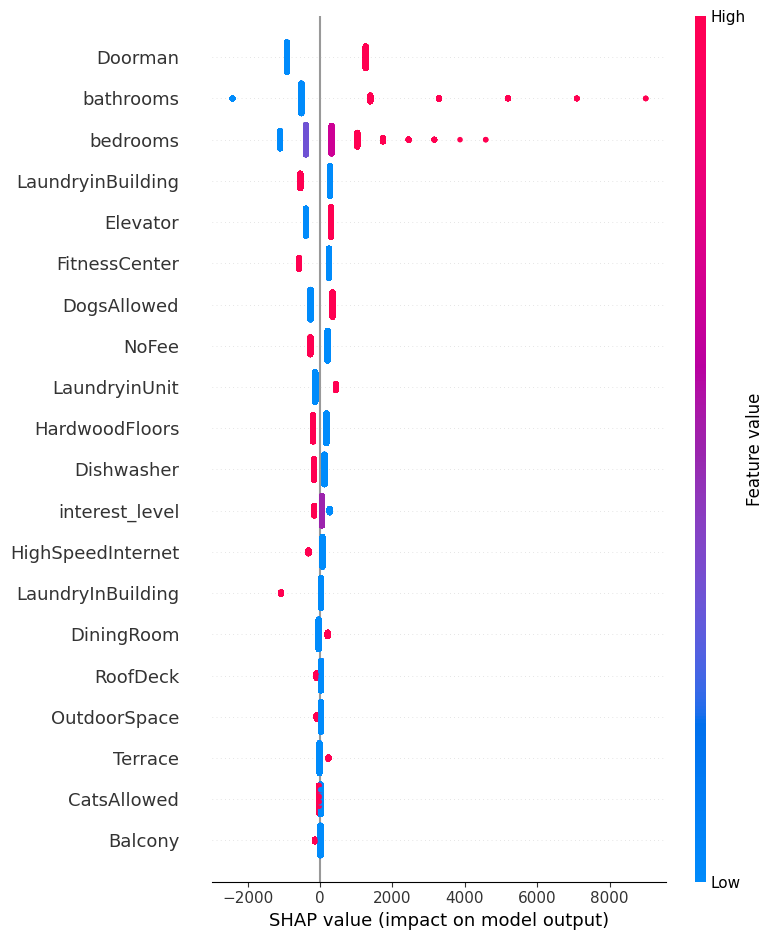

In [45]:
shap.summary_plot(shap_values, X_train)

In [46]:
shap_importance = pd.DataFrame(list(zip(X.columns, np.abs(shap_values.values).mean(axis=0))), columns=['Feature', 'Importance'])
top_features = shap_importance.sort_values(by='Importance', ascending=False).head(10)

print(top_features)

              Feature   Importance
4             Doorman  1061.681735
20          bathrooms   738.934518
21           bedrooms   666.899177
7   LaundryinBuilding   366.628098
0            Elevator   347.594654
8       FitnessCenter   336.872338
3         DogsAllowed   300.291455
6               NoFee   230.467759
10      LaundryinUnit   186.028421
2      HardwoodFloors   183.120589


In [49]:
top_feature_names = top_features['Feature'].tolist()
X_train_shap = X_train[top_feature_names]
X_valid_shap = X_valid[top_feature_names]

lasso_shap = Lasso()  
lasso_shap.fit(X_train_shap, y_train)

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [50]:
y_valid_pred_shap = lasso_shap.predict(X_valid_shap)

rmse_shap = np.sqrt(mean_squared_error(y_valid, y_valid_pred_shap))
r2_shap = r2_score(y_valid, y_valid_pred_shap)
mae_shap = mean_absolute_error(y_valid, y_valid_pred_shap)

In [51]:
print(f'RMSE shap: {rmse_shap}')
print(f'MAE shap: {mae_shap}')
print(f'R2_score shap: {r2_shap:.6}')

RMSE shap: 2102.860019504162
MAE shap: 1154.8209675404667
R2_score shap: 0.351579


лучший результат по метрикам показал метод permutation importance. Более быстрый и удобный метод дли интерпретации модели - shap.

# VII Hyperparameter optimization

## GridSearch

In [61]:
class MyGridSearch:
    
    def __init__(self, estimator, param_grid, cv):
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.best_score_ = -np.inf
        self.best_params_ = None

    def fit(self, X, y):
        param_combinations = self._generate_param_combinations(self.param_grid)

        for params in param_combinations:
            
            self.estimator.set_params(**params)
            scores = self._cross_val_score(X, y)
            mean_score = np.mean(scores)
            
            if mean_score > self.best_score_:
                self.best_score_ = mean_score
                self.best_params_ = params        
        
    def _cross_val_score(self, X, y):
        kf = KFold(n_splits=self.cv)
        scores = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            self.estimator.fit(X_train, y_train)
            score = self.estimator.score(X_test, y_test)
            scores.append(score)

        return scores
    
    def _generate_param_combinations(self, param_grid):
        keys = param_grid.keys()
        values = param_grid.values()
        return [dict(zip(keys, v)) for v in product(*values)]

# RandomSearch

In [62]:
class MyRandomSearch:
    def __init__(self, estimator, param_distributions, n_iter=10, cv=5):
        self.estimator = estimator
        self.param_distributions = param_distributions
        self.n_iter = n_iter
        self.cv = cv
        self.best_params_ = None
        self.best_score_ = -np.inf

    def fit(self, X, y):
        for _ in range(self.n_iter):
            params = self._sample_params(self.param_distributions)
            self.estimator.set_params(**params)
            scores = self._cross_val_score(X, y)

            mean_score = np.mean(scores)

            if mean_score > self.best_score_:
                self.best_score_ = mean_score
                self.best_params_ = params

    def _sample_params(self, param_distributions):
        sampled_params = {}
        for param, values in param_distributions.items():
            sampled_params[param] = np.random.choice(values)
        return sampled_params

    def _cross_val_score(self, X, y):
        kf = KFold(n_splits=self.cv)
        scores = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            self.estimator.fit(X_train, y_train)
            score = self.estimator.score(X_test, y_test)
            scores.append(score)

        return scores
    

In [83]:
import warnings
warnings.filterwarnings('ignore')


model = ElasticNet(max_iter=1000)
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0], 
    'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]  
}

grid_search = MyGridSearch(estimator=model, param_grid=param_grid, cv=10)
grid_search.fit(X_train_permutation, y_train)

print(f'Best params: {grid_search.best_params_}')

Best params: {'alpha': 100.0, 'l1_ratio': 1.0}


In [85]:
random_search = MyRandomSearch(estimator=model, param_distributions=param_grid, cv=10)
random_search.fit(X_train_permutation, y_train)

print(f'Best params: {random_search.best_params_}')

Best params: {'alpha': np.float64(100.0), 'l1_ratio': np.float64(1.0)}


два оптимизатора показали одинаковые значения

In [90]:
elastic_model = ElasticNet(alpha=100, l1_ratio=1)

elastic_model.fit(X_train_permutation, y_train)

,alpha,100
,l1_ratio,1
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [91]:
y_elastic_pred = elastic_model.predict(X_valid_permutation)

rmse_elastic = np.sqrt(mean_squared_error(y_valid, y_elastic_pred))
r2_elastic = r2_score(y_valid, y_elastic_pred)
mae_elastic= mean_absolute_error(y_valid, y_elastic_pred)

In [92]:
print(f'RMSE elastic: {rmse_elastic}')
print(f'MAE elastic: {mae_elastic}')
print(f'R2_score elastic: {r2_elastic:.6}')

RMSE elastic: 2025.3046557752255
MAE elastic: 997.3419716180756
R2_score elastic: 0.398526


## Optuna

In [82]:
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)

def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-3, 100)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    score = cross_val_score(model, X_train_permutation, y_train, cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best params", study.best_params)

Best params {'alpha': 0.16796409546845467, 'l1_ratio': 0.23841867238463182}


In [93]:
elastic_optuna = ElasticNet(alpha=0.16796409546845467, l1_ratio=0.23841867238463182)
elastic_optuna.fit(X_train_permutation, y_train)

,alpha,0.16796409546845467
,l1_ratio,0.23841867238463182
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [94]:
y_elastic_pred = elastic_optuna.predict(X_valid_permutation)

rmse_elastic = np.sqrt(mean_squared_error(y_valid, y_elastic_pred))
r2_elastic = r2_score(y_valid, y_elastic_pred)
mae_elastic= mean_absolute_error(y_valid, y_elastic_pred)

In [95]:
print(f'RMSE elastic optuna: {rmse_elastic}')
print(f'MAE elastic optuna: {mae_elastic}')
print(f'R2_score elastic optuna: {r2_elastic:.6}')

RMSE elastic optuna: 2058.7935628373484
MAE elastic optuna: 992.9525926270624
R2_score elastic optuna: 0.37847
